In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.datasets import untar_data, URLs

from exp.data import\
    ItemList,\
    grandparent_splitter,\
    SplitData,\
    random_splitter,\
    LabeledData,\
    label_by_func,\
    get_dls,\
    DataBunch

from exp.callbacks import\
    ProgressCallback,\
    AvgStatsCallback

from exp.utils import accuracy

from exp.utils import get_files
from exp.learner import Learner

from torch.optim import Adam

import PIL, torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from functools import partial

## Download Data

In [3]:
path = untar_data(URLs.MNIST)
path.ls()

[PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training'),
 PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/testing')]

## Create List Data

In [4]:
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions='.png', recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    def get(self, fn):
        return PIL.Image.open(fn)

In [5]:
imgs = ImageList.from_files(path, include=["training"])

In [6]:
imgs

ImageList (60000 items)
[PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/36655.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/32433.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/28319.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/4968.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/23502.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/37211.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/51194.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/374.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/27016.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/5492.png')...]
Path: /Users/ricardofernandez/.fastai/data/mnist_png

In [7]:
img = imgs[1]; img

## Split Data

In [8]:
sd = SplitData.split_by_func(imgs, partial(random_splitter, p_valid=0.15))

In [9]:
sd

SplitData
Train: ImageList (51129 items)
[PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/36655.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/32433.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/28319.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/4968.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/23502.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/37211.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/51194.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/374.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/27016.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/5492.png')...]
Path: /Users/ricardofernandez/.fastai/data/mnist_png

Valid: ImageList (8871 items)
[PosixPath('/Users/ricardofernandez/.fastai/data/mnist_

## Label Data

In [10]:
def mnist_label(fn):
    return int(fn.parent.name)
mnist_label(imgs.items[0])

9

In [11]:
label_data = label_by_func(sd, mnist_label)

In [12]:
label_data

SplitData
Train: LabeledData
x: ImageList (51129 items)
[PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/36655.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/32433.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/28319.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/4968.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/23502.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/37211.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/51194.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/374.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/27016.png'), PosixPath('/Users/ricardofernandez/.fastai/data/mnist_png/training/9/5492.png')...]
Path: /Users/ricardofernandez/.fastai/data/mnist_png
y: ItemList (51129 items)
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9...]
Path: /User

In [13]:
label_data.train.y

ItemList (51129 items)
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9...]
Path: /Users/ricardofernandez/.fastai/data/mnist_png

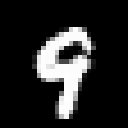

In [14]:
label_data.train[0][0].resize((128, 128))

In [15]:
img = imgs[0]

In [16]:
class Transform: _order=0
    
class ResizeFixed(Transform):
    _order=10
    def __init__(self, size):
        if isinstance(size, int): size=(size, size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)
    
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h, w, -1).permute(2, 0, 1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [17]:
transforms = [to_byte_tensor, to_float_tensor]

image_list = ImageList.from_files(path, transforms=transforms)
split_data = SplitData.split_by_func(image_list, partial(random_splitter, p_valid=0.15))
label_data = label_by_func(split_data, mnist_label)

In [18]:
label_data.train[0][0].shape

torch.Size([1, 28, 28])

In [19]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(im.view(28, 28))#permute(1,2,0))

In [20]:
label_data.train[0][0].shape

torch.Size([1, 28, 28])

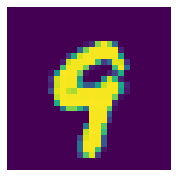

In [21]:
show_image(label_data.train[0][0])

In [22]:
train_dl, valid_dl = get_dls(label_data.train, label_data.valid, bs=8)

In [23]:
x, y = next(iter(train_dl))

In [24]:
x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

## Model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [26]:
con = nn.Conv2d(1, 8, kernel_size=8)
out = con(x)
out.shape

torch.Size([8, 8, 21, 21])

In [27]:
pool = nn.MaxPool2d(2, stride=2)
out = pool(out)
out.shape

torch.Size([8, 8, 10, 10])

In [28]:
re = nn.ReLU(True)
out = re(out)
out.shape

torch.Size([8, 8, 10, 10])

In [29]:
m = Net()
m.localization(x).shape

torch.Size([8, 10, 3, 3])

In [30]:
F.affine_grid??

In [31]:
x.size()

torch.Size([8, 1, 28, 28])

In [32]:
torch.randn(32, 6).shape

torch.Size([32, 6])

In [33]:
grid = F.affine_grid(torch.randn(8, 2, 3), x.size())
grid.shape

torch.Size([8, 28, 28, 2])

In [34]:
F.grid_sample(x, grid).shape

torch.Size([8, 1, 28, 28])

## Train

In [35]:
data = DataBunch(train_dl, valid_dl)

In [36]:
callbacks = [ProgressCallback,
             partial(AvgStatsCallback, accuracy)]

model = Net()
loss = F.cross_entropy

learn = Learner(model, data, loss, lr=0.4, cb_funcs=callbacks, opt_func=Adam)
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.621313,0.101767,2.397765,0.102173,02:06


KeyboardInterrupt: 